In this sheet I will apply Convolutional Neural Networks for stock prediction of S&P500 index. I will divide data from last 20 years into chunks. Every day contains four values: opening, low, high and closing ones - therefore input data for 30-day chunk has size 30x4. Predicted output has two classes: whether stock will go up or down or stay constant X days after last input.

In [1]:
OBSERVATION_TIME = 120
PREDICTION_AFTER_DAYS = 5
EPOCHS = 20000
TEST_SIZE = 0.1
RANDOM_SPLIT = False

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/sp500_20Y_without_covid.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000


In [3]:
def percentage_to_label(percentage_value):
    return 0 if percentage_value < 0 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

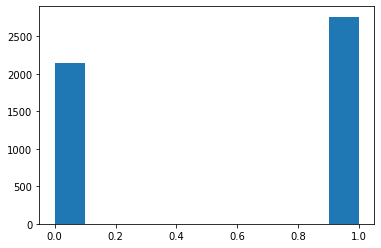

1    2761
0    2144
dtype: int64

In [4]:
import matplotlib.pyplot as plt

plt.hist(observation_results)
plt.show()

pd.Series(observation_results).value_counts()

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

In [11]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (OBSERVATION_TIME, 5), filters=16, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 120, 16)           336       
_________________________________________________________________
batch_normalization_4 (Batch (None, 120, 16)           64        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 120, 16)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 16)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 120, 8)            520       
_________________________________________________________________
batch_normalization_5 (Batch (None, 120, 8)            32        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 120, 8)           

In [6]:
from keras.optimizers import Nadam
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=METRICS)

In [7]:
from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[['Open', 'High', 'Low', 'Close', 'Adj Close']].to_numpy(), observed_chunks)))
Y = np.array(observation_results).astype('float32')

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((4414, 120, 5), (4414,), (491, 120, 5), (491,))

In [8]:
import random

def undersample_and_shuffle(X, Y):
    count_class_1, count_class_0 = pd.Series(Y).value_counts()

    lower_count = count_class_0 if count_class_0 < count_class_1 else count_class_1
    lower_class = 0 if count_class_0 < count_class_1 else 1
    
    diff = abs(count_class_0 - count_class_1)
    
    vec0 = random.sample([(x, y) for x, y in zip(X, Y) if y == 0], lower_count)
    vec1 = random.sample([(x, y) for x, y in zip(X, Y) if y == 1], lower_count)

    
    vec = vec0 + vec1
    random.shuffle(vec)
    return np.array(list(map(lambda x: x[0], vec))), np.array(list(map(lambda x: x[1], vec)))
    
X_train_balanced, Y_train_balanced = undersample_and_shuffle(X_train, Y_train)

In [9]:
pd.Series(Y_test).value_counts()

1.0    313
0.0    178
dtype: int64

In [10]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="model-binary.hdf5", save_best_only=True)

history = model.fit(x=X_train_balanced, 
                    y=Y_train_balanced, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True,
                    callbacks = [checkpointer])

ValueError: Error when checking input: expected conv1d_1_input to have shape (60, 5) but got array with shape (120, 5)

In [ ]:
history_dict = history.history
history_dict.keys()

plotted_metrics = ['precision', 'recall', 'accuracy']

fig = plt.figure(figsize=(18, 4 * len(plotted_metrics)))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for idx, metric in enumerate(plotted_metrics):
    plt.subplot(len(plotted_metrics), 2, 2*idx+1)
    plt.title(metric)
    plt.plot(history_dict[metric])
    
    plt.subplot(len(plotted_metrics), 2, 2*idx+2)
    plt.title('val_{}'.format(metric))
    plt.plot(history_dict['val_{}'.format(metric)])

plt.show()